# Ball and stick 2: Build a ring network of ball-and-stick cells

This page is the second in a series where we build a multicompartment cell and evolve it into a network of cells running on a parallel machine. In this page, we build a ring network of ball-and-stick cells created in the previous page. In this case, we make N cells where cell n makes an excitatory synapse onto cell n + 1 and the last, Nth cell in the network projects to the first cell. We will drive the first cell and visualize the spikes of the network.

In practice, you will likely want to separate the specification of the cell type and the use of that cell type into separate files, but we'll ignore that here.

## Generic cell class
<p>We'll begin by splitting the BallAndStick class into two parts: a generic Cell class and that which is specific to the BallAndStick model. This will allow us to focus our attention on the parts that we're working on and to make code that we can reuse later.</p>

First, we load the NEURON library, of course; we'll load NEURON's built-in graphics library as well to allow visual inspection of the sizes of the diameters.

In [1]:
from neuron import h, gui
from neuron.units import ms, mV

We will also want to use NEURON's standard run library, so let's go ahead and load that too:

In [2]:
h.load_file("stdrun.hoc")

1.0

The generic Cell class (we'll expand this later):

In [3]:
class Cell:
    def __init__(self, gid):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics()

    def __repr__(self):
        return "{}[{}]".format(self.name, self._gid)

And the BallAndStick class:

In [4]:
class BallAndStick(Cell):
    name = "BallAndStick"

    def _setup_morphology(self):
        self.soma = h.Section(name="soma", cell=self)
        self.dend = h.Section(name="dend", cell=self)
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1

    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100  # Axial resistance in Ohm * cm
            sec.cm = 1  # Membrane capacitance in micro Farads / cm^2
        self.soma.insert("hh")
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003  # Leak conductance in S/cm2
            seg.hh.el = -54.3  # Reversal potential in mV
        # Insert passive current in the dendrite
        self.dend.insert("pas")
        for seg in self.dend:
            seg.pas.g = 0.001  # Passive conductance in S/cm2
            seg.pas.e = -65  # Leak reversal potential mV

The only changes to the BallAndStick definition are the removal of the `__init__` and `__repr__` methods, the specification of the <tt>name</tt> of the class, the removal of the definition of <tt>self.all</tt> (now handled by the <tt>Cell</tt> class), and the change to the class declaration (the very first line) to indicate that <tt>BallAndStick</tt> is a type of <tt>Cell</tt>.

## Adjusting position and orientation

When we have more than one cell, we'd like to be able to position them so that we can see them clearly. We'll introduce new methods `_set_position` and `_rotate_z` to the Cell class to allow us to do this:

In [5]:
class Cell:
    def __init__(self, gid, x, y, z, theta):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics()
        self.x = self.y = self.z = 0  # <-- NEW
        h.define_shape()
        self._rotate_z(theta)  # <-- NEW
        self._set_position(x, y, z)  # <-- NEW

    def __repr__(self):
        return "{}[{}]".format(self.name, self._gid)

    # everything below here is NEW

    def _set_position(self, x, y, z):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(
                    i,
                    x - self.x + sec.x3d(i),
                    y - self.y + sec.y3d(i),
                    z - self.z + sec.z3d(i),
                    sec.diam3d(i),
                )
        self.x, self.y, self.z = x, y, z

    def _rotate_z(self, theta):
        """Rotate the cell about the Z axis."""
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i)
                y = sec.y3d(i)
                c = h.cos(theta)
                s = h.sin(theta)
                xprime = x * c - y * s
                yprime = x * s + y * c
                sec.pt3dchange(i, xprime, yprime, sec.z3d(i), sec.diam3d(i))

If you are writing a script to do this, and revising the classes as we make changes, everything should be good. If you are following along in a Jupyter notebook, you will need to rerun the definition of BallAndStick above for the changes to take effect:

In [6]:
## Run only for jupyter
class BallAndStick(Cell):
    name = "BallAndStick"

    def _setup_morphology(self):
        self.soma = h.Section(name="soma", cell=self)
        self.dend = h.Section(name="dend", cell=self)
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1

    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100  # Axial resistance in Ohm * cm
            sec.cm = 1  # Membrane capacitance in micro Farads / cm^2
        self.soma.insert("hh")
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003  # Leak conductance in S/cm2
            seg.hh.el = -54.3  # Reversal potential in mV
        # Insert passive current in the dendrite
        self.dend.insert("pas")
        for seg in self.dend:
            seg.pas.g = 0.001  # Passive conductance in S/cm2
            seg.pas.e = -65  # Leak reversal potential mV

Let's create a test cell. Note that we now have to specify `x`, `y`, `z`, and `theta` in addition to the `gid`.

In [7]:
mycell = BallAndStick(0, 0, 0, 0, 0)

If you got a `TypeError`, that means you did not rerun the definition of BallAndStick. Go back and do that and then the above should work.

We no longer need the test cell, so let's delete it:

In [8]:
del mycell

## Construct and position our cells

We want to construct an arbitrary number of cells and position them in a circle. For the sake of reusability, we'll make a function that takes two parameters: `N`, the number of cells, and `r` the radius of the circle (in microns). This function will return a list of `N` cells centered around the origin on the XY plane:

In [9]:
def create_n_BallAndStick(n, r):
    """n = number of cells; r = radius of circle"""
    cells = []
    for i in range(n):
        theta = i * 2 * h.PI / n
        cells.append(BallAndStick(i, h.cos(theta) * r, h.sin(theta) * r, 0, theta))
    return cells

Let's create 7 cells with r = 50 microns:

In [10]:
my_cells = create_n_BallAndStick(7, 50)

Let's plot them using NEURON's built-in graphics:

In [11]:
ps = h.PlotShape(True)
ps.show(0)

1.0

Using functions like this is extremely flexible. We can switch to 5 cells like this:

In [12]:
my_cells = create_n_BallAndStick(5, 50)

The old cells disappear (they get garbage collected, as there are no longer any references to them), and the new cells appear in the existing graph.

## A first synapse, and input via a NetStim

Okay, we have our ball-and-stick cells arranged in a ring. Let’s now stimulate a cell and see that it responds appropriately. Instead of stimulating with a current electrode as we did before, let’s assign a virtual synapse so that we get acquainted with driving the cells through synaptic events.

Event-based communication between objects in NEURON takes place via network connection objects called <a href="https://neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/network/netcon.html#NetCon">NetCon</a>s. Each NetCon has a source and target, where the source is typically a spike threshold detector. When a spike is detected, the NetCon sends a message to a target, usually a synapse on a postsynaptic cell.

A <a href="https://neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html#NetStim">NetStim</a> is a spike generator that can be used as the source in a NetCon, behaving as external input onto the synapse of a target cell. The following code makes a NetStim object that generates one spike at time t=9. The NetCon then adds another ms delay to deliver a synaptic event at time t=10 onto the first cell.

The code below makes a stimulator and attaches it to a synapse object (<a href="https://neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html#ExpSyn">ExpSyn</a>) that behaves much like an AMPA synapse – it conducts current as a decaying exponential function.

In [13]:
stim = h.NetStim()  # Make a new stimulator

## Attach it to a synapse in the middle of the dendrite
## of the first cell in the network. (Named 'syn_' to avoid
## being overwritten with the 'syn' var assigned later.)
syn_ = h.ExpSyn(my_cells[0].dend(0.5))

stim.number = 1
stim.start = 9
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 1 * ms
ncstim.weight[0] = 0.04  # NetCon weight is a vector.

Exponentially decaying currents, such as that generated by the synapse `syn_` have dynamics that depend on `tau`, the time constant. Let's specify a time constant of 2 ms:

In [14]:
syn_.tau = 2 * ms

The parameter `tau` specifies how quickly the currents decay. The exact value of the current depends on the cell's membrane potential, and the synapse's reversal potential, `syn_.e`.

In [15]:
print("Reversal potential = {} mV".format(syn_.e))

Reversal potential = 0.0 mV


## Running and plotting a simulation

Right now, there are no synapses between cells, but let's confirm that the first cell works correctly:

### Recording

In [16]:
recording_cell = my_cells[0]
soma_v = h.Vector().record(recording_cell.soma(0.5)._ref_v)
dend_v = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

### Simulating

In [17]:
h.finitialize(-65 * mV)
h.continuerun(25 * ms)

0.0

### Plotting

As before, if you're running in a Jupyter notebook, you'll need to tell it to display plots inline. Skip this step if you are running from a script:

In [18]:
%matplotlib inline

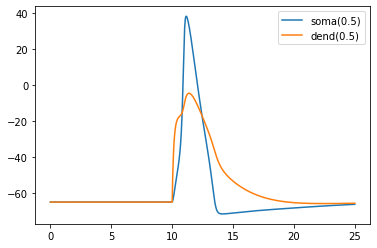

In [19]:
import matplotlib.pyplot as plt

plt.plot(t, soma_v, label="soma(0.5)")
plt.plot(t, dend_v, label="dend(0.5)")
plt.legend()
plt.show()

### Recording synaptic conductance

To understand the above graph, we may wish to consider the time series of synaptic current. Let's create a new Vector to monitor that:

In [20]:
syn_i = h.Vector().record(syn_._ref_i)

Only data that is explicitly recorded during a simulation is stored, so we will have to rerun the simulation to compute those currents:

In [21]:
h.finitialize(-65 * mV)
h.continuerun(25 * ms)

0.0

Now we can plot:

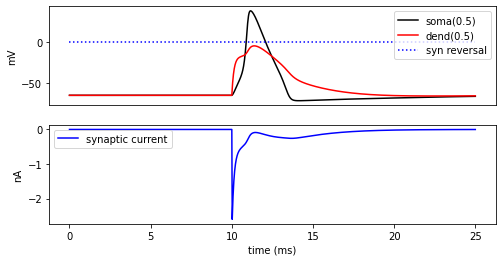

In [22]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(2, 1, 1)
soma_plot = ax1.plot(t, soma_v, color="black", label="soma(0.5)")
dend_plot = ax1.plot(t, dend_v, color="red", label="dend(0.5)")
rev_plot = ax1.plot(
    [t[0], t[-1]], [syn_.e, syn_.e], label="syn reversal", color="blue", linestyle=":"
)
ax1.legend()
ax1.set_ylabel("mV")
ax1.set_xticks([])  # Use ax2's tick labels

ax2 = fig.add_subplot(2, 1, 2)
syn_plot = ax2.plot(t, syn_i, color="blue", label="synaptic current")
ax2.legend()
ax2.set_ylabel(h.units("ExpSyn.i"))
ax2.set_xlabel("time (ms)")
plt.show()

Try setting the recording vectors to one of the other cells. They should be unresponsive to the stimulus.

## Connecting the cells

Okay. We have our ball-and-stick cells arranged in a ring, and we have attached a stimulus onto the first cell. Next, we need to connect an axon from cell n to a synapse at the middle of the dendrite on cell n + 1. For this model, the particular dynamics of the axons do not need to be explicitly modeled. When the soma fires an action potential, we assume the spike propagates down the axon and induces a synaptic event onto the dendrite of the target cell with some delay. We can therefore connect a spike detector in the soma of the presynaptic cell that triggers a synaptic event in the target cell via a <a href="https://neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/network/netcon.html#NetCon">NetCon</a>.



In [23]:
syns = []
netcons = []
for source, target in zip(my_cells, my_cells[1:] + [my_cells[0]]):
    syn = h.ExpSyn(target.dend(0.5))
    nc = h.NetCon(source.soma(0.5)._ref_v, syn, sec=source.soma)
    nc.weight[0] = 0.05
    nc.delay = 5
    netcons.append(nc)
    syns.append(syn)

The `zip` pairs each cell with the next cell, where the addition places the first cell as the cell after the last cell. The seemingly repetitive specification of the source section in the `NetCon` constructor's `sec=` argument is required for technical reasons.

Let's see what happens to the first cell:

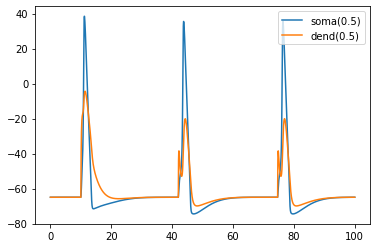

In [24]:
h.finitialize(-65 * mV)
h.continuerun(100 * ms)
plt.plot(t, soma_v, label="soma(0.5)")
plt.plot(t, dend_v, label="dend(0.5)")
plt.legend()
plt.show()

Here we of course only plotting `my_cells[0]`, but the fact that it spikes more than just once suggests that spikes are being transmitted throughout the network.

<b>As an exercise</b>, try rerunning the above plotting `my_cells[1]` alternatively or in-addition to `my_cells[0]`.

We can ask each of our existing `NetCon`s to record spike times in NEURON `Vector` objects using <a href="https://neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/network/netcon.html#NetCon.record">NetCon.record</a>:

In [25]:
spike_times = [h.Vector() for nc in netcons]
for nc, spike_times_vec in zip(netcons, spike_times):
    nc.record(spike_times_vec)

Once again, we rerun everything to 100 ms:

In [26]:
h.finitialize(-65 * mV)
h.continuerun(100 * ms)

0.0

Print out the results:

In [27]:
for i, spike_times_vec in enumerate(spike_times):
    print("cell {}: {}".format(i, list(spike_times_vec)))

cell 0: [10.925000000099914, 43.55000000010134, 76.17500000010875]
cell 1: [17.450000000099543, 50.075000000102825, 82.70000000011024]
cell 2: [23.975000000099172, 56.60000000010431, 89.22500000011172]
cell 3: [30.5000000000988, 63.12500000010579, 95.7500000001132]
cell 4: [37.02500000009986, 69.65000000010727]


Each line represents one cell and lists all the times it fires: cell 0 fires first, then 1, 2, 3, 4, back to 0, etc.

A more intuitive way of seeing this is to use a raster plot. Here's how to do that with matplotlib:

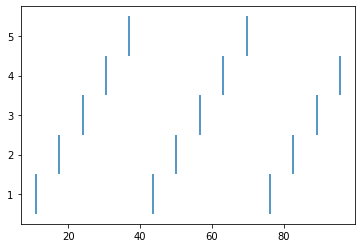

In [28]:
import matplotlib.pyplot as plt

plt.figure()

for i, spike_times_vec in enumerate(spike_times):
    plt.vlines(spike_times_vec, i + 0.5, i + 1.5)
plt.show()

This page has demonstrated various functionality to arrange, connect, and visualize a network and its output. As nice as it may seem, it needs some design work to make it flexible. The next part of the tutorial further organizes the functionality into more classes to make it more easily extended.